# Part-4 
- Predict wether the review is positive or negative
- Group number S21DL20
-  Team members 
   - Manjju Shree Devy       S20180010055
   - Swathi Kedarasetty      S20180010172
   - Korupoulu Saideepthi    S20180010087
   - Varakala Sowmya         S20180010187
   
   

## About the Dataset
A set of 50,000 highly polar movie reviews. 

## Task
Predict wether the review is positive or negative 

## Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
# to load, access, process and dump json files
import json
# regular repression
import re
# for numerical analysis
import numpy as np 
# to store and process in a dataframe
import pandas as pd 

# for ploting graphs
import matplotlib.pyplot as plt
# advancec ploting
import seaborn as sns
# to create word clouds
from wordcloud import WordCloud, STOPWORDS 

# To encode values
from sklearn.preprocessing import LabelEncoder
# Convert a collection of text documents to a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer
# confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
# train test split
from sklearn.model_selection import train_test_split

# for deep learning 
import tensorflow as tf
# to tokenize text
from tensorflow.keras.preprocessing.text import Tokenizer
# to pad sequence 
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Utility Function

In [3]:
def plot_ngram(sentiment, n):
    
    temp_df = df[df['sentiment'] == sentiment]
    
    word_vectorizer = CountVectorizer(ngram_range=(n, n), analyzer='word')
    sparse_matrix = word_vectorizer.fit_transform(temp_df['review'])
    
    frequencies = sum(sparse_matrix).toarray()[0]
    
    return pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])\
            .sort_values(by='frequency', ascending=False) \
            .reset_index() \
            .head(10)

In [4]:
def plot_wordcloud(review, cmap):
    fig, ax = plt.subplots(figsize=(8, 6))
    wc = WordCloud(max_words = 1000, background_color ='white', stopwords = stopwords, 
                   min_font_size = 10, colormap=cmap)
    wc = wc.generate(review)
    plt.axis('off')
    plt.imshow(wc)

In [5]:
# to plot model accuracy and loss

def plot_history(history):
    
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', c='green', lw='2')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', c='orangered', lw='2')
    plt.title('Accuracy', loc='left', fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', c='green', lw='2')
    plt.plot(history.history['val_loss'], label='Validation Loss', c='orangered', lw='2')
    plt.title('Loss', loc='left', fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [6]:
# to plot confusion matrix
# ========================

def plot_cm(pred, ticklabels, figsize):
    
    pred = pred.ravel()
    pred = np.round(pred)
      
    fig, ax = plt.subplots(1, 1, figsize=(figsize, figsize))

    cm = confusion_matrix(validation_labels, pred)
    sns.heatmap(cm, annot=True, cbar=False, fmt='1d', cmap='Blues', ax=ax)

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(ticklabels)
    ax.set_yticklabels(ticklabels, rotation=0)

    plt.show()

## Dataset

In [8]:
# read the data
df = pd.read_csv("/content/drive/MyDrive/DL/IMDB Dataset.csv")

# shape
print('No. of rows and columns :', df.shape)

# first few rows
df.head()

No. of rows and columns : (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## Stopwords

In [9]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", 
             "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by",
             "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", 
             "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers",
             "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", 
              "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor",
              "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own",
              "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's",
              "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd",
              "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very",
              "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", 
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're",
             "you've", "your", "yours", "yourself", "yourselves" ]

# specific stopwords
specific_sw = ['br', 'movie', 'film']

# all stopwords
stopwords = stopwords + specific_sw

## No. of reviews in with each sentiment

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


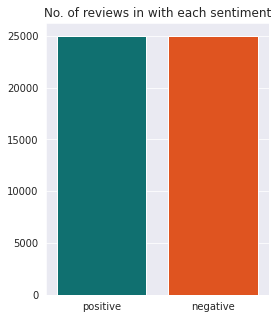

In [10]:
sns.set_style('darkgrid')
plt.figure(figsize=(4, 5))
sns.countplot(df['sentiment'], palette=['teal', 'orangered'])
plt.title('No. of reviews in with each sentiment')
plt.xlabel("")
plt.ylabel("")
plt.show()

## Plots

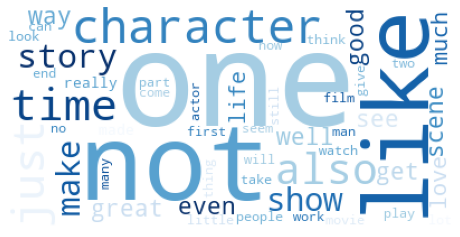

In [11]:
# word cloud on positve reviews
pos_rev = ' '.join(df[df['sentiment']=='positive']['review'].to_list()[:10000])
plot_wordcloud(pos_rev, 'Blues')

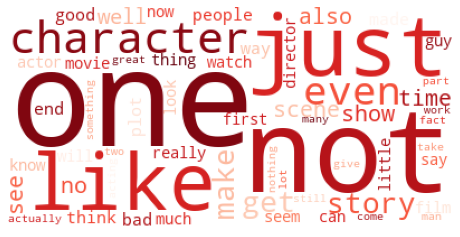

In [12]:
# word cloud on positve reviews
neg_rev = ' '.join(df[df['sentiment']=='negative']['review'].to_list()[:10000])
plot_wordcloud(neg_rev, 'Reds')

In [13]:
plot_ngram('positive', 1)

,index,frequency
0,the,341281
1,and,176634
2,of,152105
3,to,131322
4,is,111830
5,in,99250
6,br,97954
7,it,95133
8,this,69648
9,that,69593


In [14]:
plot_ngram('negative', 1)

,index,frequency
0,the,326712
1,and,147807
2,of,137305
3,to,136802
4,br,103997
5,is,99252
6,it,95724
7,in,87531
8,this,81354
9,that,74286


## Preprocessing Data

In [20]:
# to remove non alphanumeric character
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

# to remove the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# to remove URLs
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# to remove html tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [21]:
# apply preprocessing steps

df['review'] = df['review'].apply(remove_URL)
df['review'] = df['review'].apply(remove_html)
df['review'] = df['review'].str.lower()
df['review'] = df['review'].apply(alpha_num)
df['review'] = df['review'].apply(remove_stopwords)

df.head()

,review,sentiment
0,one reviewers mentioned watching just 1 oz epi...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive


## Get review and labels

In [22]:
# container for sentences
reviews = np.array([review for review in df['review']])

# container for labels
labels = np.array([label for label in df['sentiment']])

## Label encode sentiment

In [23]:
# label encoding labels 

enc = LabelEncoder()
encoded_labels = enc.fit_transform(labels)

print(enc.classes_)
print(labels[:5])
print(encoded_labels[:5])

['negative' 'positive']
['positive' 'positive' 'positive' 'negative' 'positive']
[1 1 1 0 1]


## Train Test Split

In [24]:
# train-test split
train_sentences, validation_sentences, train_labels, validation_labels = train_test_split(reviews, encoded_labels, 
                                                                                          test_size=0.33, 
                                                                                          stratify=labels)

## Model parameters

In [30]:
# model parameters

vocab_size = len(word_index)
embedding_dim = 100
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

## Tokenize and Sequence text

In [31]:
# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

# convert validation dataset to sequence and pad sequences
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

# With Word Embedding

In [32]:
# model initialization
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 100)          17157800  
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                2424      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 17,160,249
Trainable params: 17,160,249
Non-trainable params: 0
_________________________________________________________________


In [33]:
# fit model
num_epochs = 10
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.3)

# predict values
pred = model.predict(validation_padded)

Epoch 1/10
733/733 - 113s - loss: 0.3969 - accuracy: 0.8386 - val_loss: 0.2780 - val_accuracy: 0.8887
Epoch 2/10
733/733 - 109s - loss: 0.1521 - accuracy: 0.9467 - val_loss: 0.2995 - val_accuracy: 0.8824
Epoch 3/10
733/733 - 109s - loss: 0.0624 - accuracy: 0.9826 - val_loss: 0.3572 - val_accuracy: 0.8848
Epoch 4/10
733/733 - 109s - loss: 0.0247 - accuracy: 0.9942 - val_loss: 0.4194 - val_accuracy: 0.8801
Epoch 5/10
733/733 - 109s - loss: 0.0097 - accuracy: 0.9982 - val_loss: 0.4812 - val_accuracy: 0.8768
Epoch 6/10
733/733 - 109s - loss: 0.0040 - accuracy: 0.9994 - val_loss: 0.5354 - val_accuracy: 0.8748
Epoch 7/10
733/733 - 108s - loss: 0.0018 - accuracy: 0.9998 - val_loss: 0.5879 - val_accuracy: 0.8754
Epoch 8/10
733/733 - 109s - loss: 9.2103e-04 - accuracy: 0.9999 - val_loss: 0.6312 - val_accuracy: 0.8751
Epoch 9/10
733/733 - 109s - loss: 5.1148e-04 - accuracy: 1.0000 - val_loss: 0.6711 - val_accuracy: 0.8711
Epoch 10/10
733/733 - 108s - loss: 3.2642e-04 - accuracy: 1.0000 - val_los

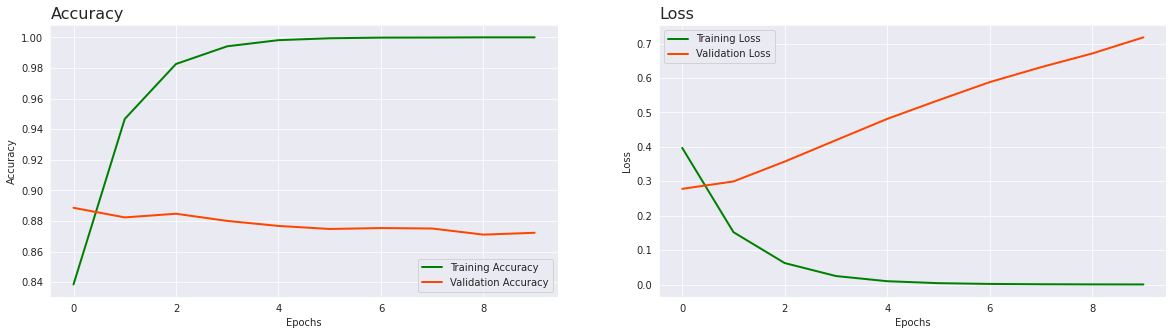

In [34]:
# plot history
plot_history(history)

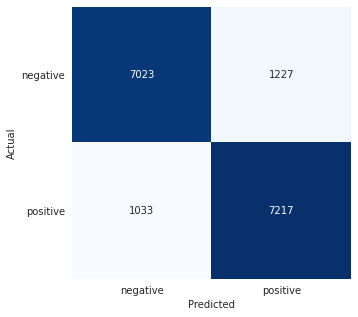

In [35]:
# plot confusion matrix
plot_cm(pred, enc.classes_, 5)

In [36]:
# reviews on which we need to predict
sentence = ["The movie was very touching and heart whelming", 
            "I have never seen a terrible movie like this"]

# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

# pad the sequence
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# preict the label
print(model.predict(padded))

[[0.9927736 ]
 [0.04627678]]


# With LSTM

In [37]:
# model initialization
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 100)          17157800  
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense_2 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 17,245,401
Trainable params: 17,245,401
Non-trainable params: 0
_________________________________________________________________


In [38]:
# fit model
num_epochs = 10
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.33)

# predict values
pred = model.predict(validation_padded)

Epoch 1/10
702/702 - 148s - loss: 0.3787 - accuracy: 0.8261 - val_loss: 0.2866 - val_accuracy: 0.8817
Epoch 2/10
702/702 - 115s - loss: 0.1235 - accuracy: 0.9570 - val_loss: 0.3426 - val_accuracy: 0.8712
Epoch 3/10
702/702 - 116s - loss: 0.0401 - accuracy: 0.9871 - val_loss: 0.4229 - val_accuracy: 0.8647
Epoch 4/10
702/702 - 116s - loss: 0.0215 - accuracy: 0.9936 - val_loss: 0.5193 - val_accuracy: 0.8660
Epoch 5/10
702/702 - 116s - loss: 0.0172 - accuracy: 0.9947 - val_loss: 0.6104 - val_accuracy: 0.8585
Epoch 6/10
702/702 - 115s - loss: 0.0127 - accuracy: 0.9958 - val_loss: 0.6568 - val_accuracy: 0.8626
Epoch 7/10
702/702 - 115s - loss: 0.0091 - accuracy: 0.9973 - val_loss: 0.5730 - val_accuracy: 0.8488
Epoch 8/10
702/702 - 115s - loss: 0.0074 - accuracy: 0.9976 - val_loss: 0.9517 - val_accuracy: 0.8476
Epoch 9/10
702/702 - 115s - loss: 0.0103 - accuracy: 0.9967 - val_loss: 0.7093 - val_accuracy: 0.8571
Epoch 10/10
702/702 - 115s - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.8211 - 

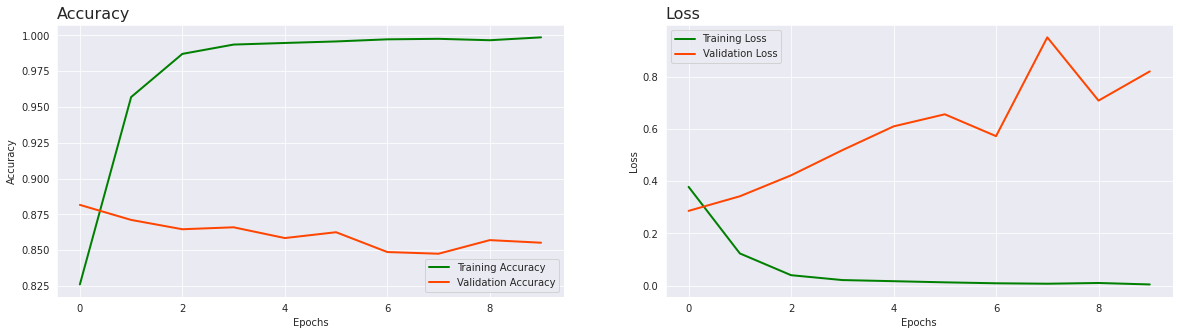

In [39]:
# plot history
plot_history(history)

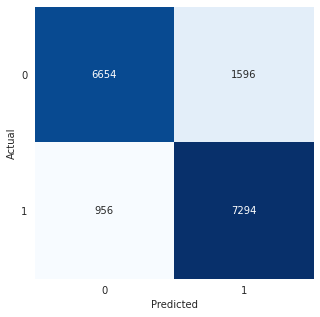

In [48]:
# plot confusion matrix
plot_cm(pred, enc.classes_, 5)


In [49]:
# reviews on which we need to predict
sentence = ["The movie was very touching and heart whelming", 
            "I have never seen a terrible movie like this"]

# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

# pad the sequence
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# preict the label
print(model.predict(padded))

[[0.99409   ]
 [0.02027406]]


# LSTM - 2 Layer

In [50]:
# model initialization
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 100)          17157800  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 120, 128)          84480     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_4 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 17,285,081
Trainable params: 17,285,081
Non-trainable params: 0
_________________________________________________________________


In [52]:
# fit model
num_epochs = 10
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.33)

# predict values
pred = model.predict(validation_padded)

Epoch 1/10
702/702 - 133s - loss: 0.4003 - accuracy: 0.8164 - val_loss: 0.2921 - val_accuracy: 0.8800
Epoch 2/10
702/702 - 127s - loss: 0.1301 - accuracy: 0.9544 - val_loss: 0.3531 - val_accuracy: 0.8688
Epoch 3/10
702/702 - 126s - loss: 0.0379 - accuracy: 0.9895 - val_loss: 0.4844 - val_accuracy: 0.8594
Epoch 4/10
702/702 - 127s - loss: 0.0196 - accuracy: 0.9941 - val_loss: 0.5784 - val_accuracy: 0.8582
Epoch 5/10
702/702 - 127s - loss: 0.0164 - accuracy: 0.9949 - val_loss: 0.7489 - val_accuracy: 0.8528
Epoch 6/10
702/702 - 127s - loss: 0.0176 - accuracy: 0.9941 - val_loss: 0.7066 - val_accuracy: 0.8541
Epoch 7/10
702/702 - 127s - loss: 0.0152 - accuracy: 0.9947 - val_loss: 0.6790 - val_accuracy: 0.8552
Epoch 8/10
702/702 - 127s - loss: 0.0060 - accuracy: 0.9980 - val_loss: 0.8809 - val_accuracy: 0.8528
Epoch 9/10
702/702 - 126s - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.7652 - val_accuracy: 0.8433
Epoch 10/10
702/702 - 127s - loss: 0.0062 - accuracy: 0.9980 - val_loss: 0.9399 - 

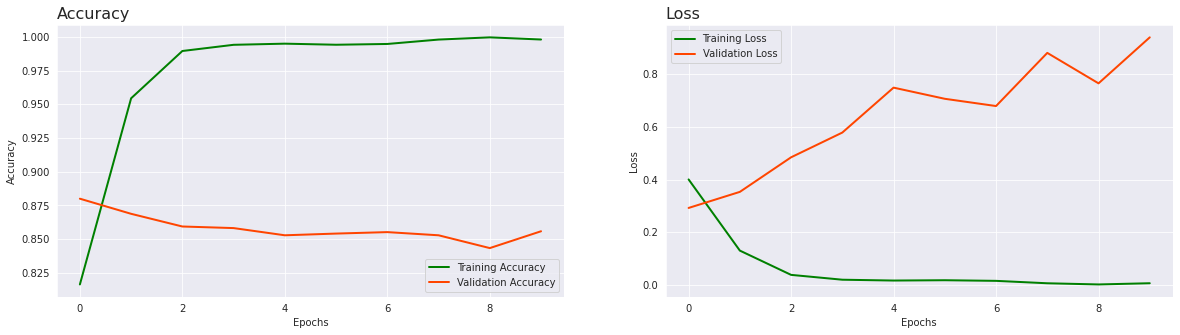

In [53]:
# plot history
plot_history(history)

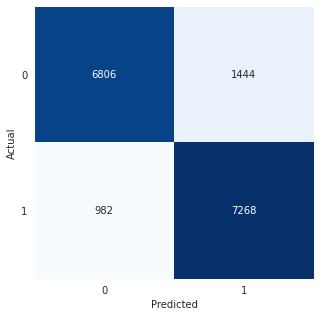

In [54]:
# plot confusion matrix
plot_cm(pred, enc.classes_, 5)

In [55]:
# reviews on which we need to predict
sentence = ["The movie was very touching and heart whelming", 
            "I have never seen a terrible movie like this"]

# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

# pad the sequence
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# preict the label
print(model.predict(padded))

[[0.99892044]
 [0.00147514]]


# With GRU

In [56]:
# model initialization
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 100)          17157800  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               63744     
_________________________________________________________________
dense_6 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 17,224,665
Trainable params: 17,224,665
Non-trainable params: 0
_________________________________________________________________


In [57]:
# fit model
num_epochs = 10
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.33)

# predict values
pred = model.predict(validation_padded)

Epoch 1/10
702/702 - 119s - loss: 0.3958 - accuracy: 0.8153 - val_loss: 0.2940 - val_accuracy: 0.8809
Epoch 2/10
702/702 - 116s - loss: 0.1259 - accuracy: 0.9564 - val_loss: 0.3357 - val_accuracy: 0.8713
Epoch 3/10
702/702 - 116s - loss: 0.0364 - accuracy: 0.9881 - val_loss: 0.4561 - val_accuracy: 0.8539
Epoch 4/10
702/702 - 116s - loss: 0.0134 - accuracy: 0.9953 - val_loss: 0.7758 - val_accuracy: 0.8391
Epoch 5/10
702/702 - 116s - loss: 0.0100 - accuracy: 0.9967 - val_loss: 0.6222 - val_accuracy: 0.8591
Epoch 6/10
702/702 - 116s - loss: 0.0092 - accuracy: 0.9971 - val_loss: 0.6432 - val_accuracy: 0.8642
Epoch 7/10
702/702 - 116s - loss: 0.0043 - accuracy: 0.9984 - val_loss: 0.7785 - val_accuracy: 0.8612
Epoch 8/10
702/702 - 115s - loss: 0.0052 - accuracy: 0.9985 - val_loss: 0.7597 - val_accuracy: 0.8563
Epoch 9/10
702/702 - 116s - loss: 0.0046 - accuracy: 0.9986 - val_loss: 0.8875 - val_accuracy: 0.8512
Epoch 10/10
702/702 - 116s - loss: 0.0061 - accuracy: 0.9980 - val_loss: 0.8739 - 

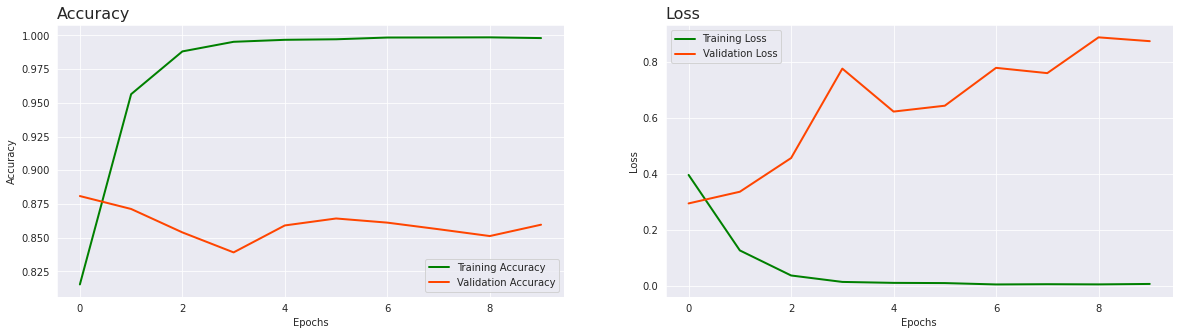

In [58]:
# plot history
plot_history(history)

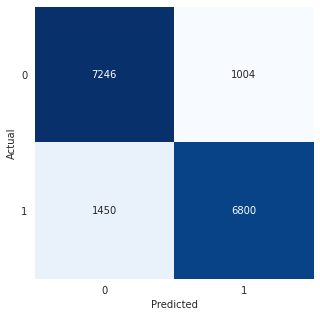

In [59]:
# plot confusion matrix
plot_cm(pred, enc.classes_, 5)

In [63]:
# reviews on which we need to predict
sentence = ["The movie was very touching and heart whelming", 
            "I have never seen a terrible movie like this"]

# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

# pad the sequence
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# preict the label
print(model.predict(padded))

[[9.959377e-01]
 [4.569204e-05]]


# With Convolution

In [66]:
# model initialization
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 100)          17157800  
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 25        
Total params: 17,225,049
Trainable params: 17,225,049
Non-trainable params: 0
_________________________________________________________________


In [67]:
# fit model
num_epochs = 10
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.33)

# predict values
pred = model.predict(validation_padded)

Epoch 1/10
702/702 - 110s - loss: 0.4042 - accuracy: 0.8106 - val_loss: 0.2994 - val_accuracy: 0.8751
Epoch 2/10
702/702 - 108s - loss: 0.1203 - accuracy: 0.9585 - val_loss: 0.3279 - val_accuracy: 0.8717
Epoch 3/10
702/702 - 108s - loss: 0.0098 - accuracy: 0.9989 - val_loss: 0.3905 - val_accuracy: 0.8752
Epoch 4/10
702/702 - 108s - loss: 5.7575e-04 - accuracy: 1.0000 - val_loss: 0.4214 - val_accuracy: 0.8756
Epoch 5/10
702/702 - 108s - loss: 2.1270e-04 - accuracy: 1.0000 - val_loss: 0.4464 - val_accuracy: 0.8755
Epoch 6/10
702/702 - 108s - loss: 1.1618e-04 - accuracy: 1.0000 - val_loss: 0.4671 - val_accuracy: 0.8752
Epoch 7/10
702/702 - 108s - loss: 6.9293e-05 - accuracy: 1.0000 - val_loss: 0.4871 - val_accuracy: 0.8746
Epoch 8/10
702/702 - 108s - loss: 4.3154e-05 - accuracy: 1.0000 - val_loss: 0.5059 - val_accuracy: 0.8740
Epoch 9/10
702/702 - 108s - loss: 2.7560e-05 - accuracy: 1.0000 - val_loss: 0.5241 - val_accuracy: 0.8743
Epoch 10/10
702/702 - 109s - loss: 1.7923e-05 - accuracy: 

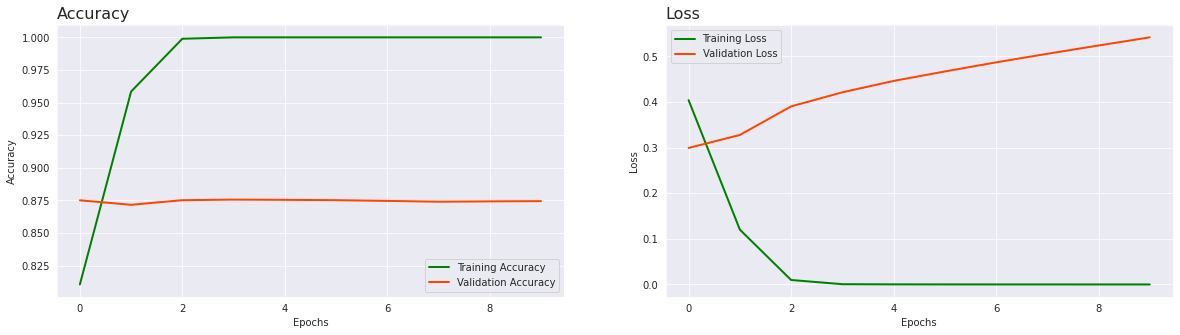

In [69]:
# plot history
plot_history(history)

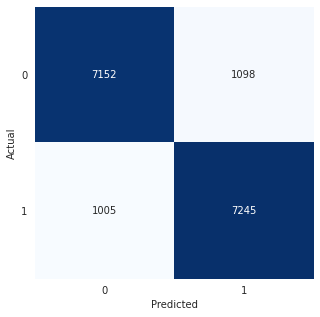

In [70]:
# plot confusion matrix
plot_cm(pred, enc.classes_, 5)

In [71]:
# reviews on which we need to predict
sentence = ["The movie was very touching and heart whelming", 
            "I have never seen a terrible movie like this"]

# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

# pad the sequence
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# preict the label
print(model.predict(padded))

[[9.999999e-01]
 [7.506409e-05]]
